In [1]:
# ----------------------------------------------------- #
# ------- BEGIN: MAIN FUNCTIONS AND DEFINITIONS ------- #
# ----------------------------------------------------- #

In [2]:
#
# Label of an edge joining roots u and v
#
def label(u,v):
    return bL(u,v)**2/fL(u)/fL(v); # value of cos^2 or cosh^2 

In [3]:
#
# Constructing a diagram using outer normals of a polyhedron
# Labels are given by squares of inner products of normals
#
def diagram(normals):
    g = Graph();
    l = len(normals);
    for i in range(l):
        for j in range(l):
            if i<j:
                w = label(normals[i],normals[j]);
                g.add_vertices([i,j]);
                if w!=0:
                    g.add_edge(i,j,w);
    return g;

In [4]:
#
# Is given polyhedron of Coxeter type ? Needs diagram with weighted edges
#
def is_Coxeter(diag):
    for e in diag.edges():
        weight = e[2];
        if weight < 1:
            k = round(pi/arccos(sqrt(weight)));
            if not(minpoly(weight)==minpoly(cos(pi/k)**2)):
                return False;
    return True;

In [5]:
#
# Coxeter diagram using outer normals of a polyhedron
# Labels are integers:
# n\geq 3 : angle of \pi/n
# n = 0 : angle of 0, label \infinity, or bold edge
# n = 1 : common perpendicular, dotted edge
#
def Coxeter_diagram(normals):
    g = Graph();
    l = len(normals);
    for i in range(l):
        for j in range(l):
            if (i<j):
                u = normals[i];
                v = normals[j];
                weight = bL(u,v)**2/fL(u)/fL(v);
                if weight<1:
                    k = round(pi/arccos(sqrt(weight)));
                    g.add_vertex(i);
                    g.add_vertex(j);
                    if k>2:
                        g.add_edge(i,j,k);
                else:
                    if weight==1:
                        g.add_edge(i,j,0);
                    else:
                        g.add_edge(i,j,1);
    return g;

In [6]:
#
# Projecting vector w onto __orthogonal__complement__ of W
#
def proj(w, W): 
    ww = sum([bL(vv,w)/fL(vv)*vv for vv in W]);
    return w - ww;

In [7]:
#
# Producing the list of facets of a polyhedron given as 
# (set of normals of sub-face, its diagram, symmetry group,
# index of normal vector of super-face, angles between sub-face and its neighbours).
#
# Here, the first 3 entries represent the most important data, while the last two 
# are useful for tracing adjacency and play the role of auxiliary data. 
#
# All angles between the sub-face and its neighbours are given as k, for an angle of \pi/k.  
#
# Each isometry type of a facet happens only __once__
#
def facets(normals, diag, aut):
    f_list = [];
    f = list(map(lambda x: sorted(x)[0], aut.orbits()));
    for i in f:
        f_poly = [proj(w, [normals[i]]) for w in normals if bL(w,normals[i])**2/fL(w)/fL(normals[i])<1];
        d_poly = diagram(f_poly);
        a_poly = d_poly.automorphism_group(edge_labels=True);
        flag = True;
        count = 0;
        while flag and (count<len(f_list)):            
            flag = flag and not(d_poly.is_isomorphic(f_list[count][1]));
            count += 1;
        if flag:
            f_list += [(f_poly, d_poly, a_poly)];
    return f_list;

In [8]:
#
# Augmenting the facet tree
# IMPORTANT: vertices are enumerated in no particular order
#
def augment_facet_tree(T):
    max_dist = max([T.distance(0,t) for t in T.vertices()]);
    for t in T.vertices():
        if T.distance(0,t)==max_dist:
            m = max(T.vertices());
            s = facets(*T.get_vertex(t));
            for i in range(len(s)):
                T.add_edge(t, m+i+1);
                T.set_vertex(m+i+1, s[i]);

In [9]:
#
# Pruning the facet tree: removing repeated isometry types of non-Coxeter descendants
# IMPORTANT: vertices are enumerated in no particular order
#
def prune_facet_tree(T):
    leaves = [t for t in T.vertices() if T.degree(t)<2 and t!=0];
    pruned = [];
    for l in leaves:
        if all([not T.get_vertex(l)[1].is_isomorphic(T.get_vertex(ll)[1], edge_labels=True) for ll in pruned]):
            pruned += [l];
    for l in leaves:
        if not(l in pruned):
            T.delete_vertex(l);

In [10]:
#
# Checking if a facets is orthogonal to its neighbours: needs Coxeter diagram
#
def is_orthogonal(diag, v):
    weights = [e[2] for e in diag.edges_incident([v], labels=True)];
    return all([(w==0)or(w==1) for w in weights]);
#
# Checking if a polyhedron defined by a set of normals has an orthogonal facet
#
def has_orthogonal_facet(diag):
    for v in diag.vertices():
        if is_orthogonal(diag, v):
            return True;
    return False;
#
# Checking if a given facet has angles pi/2 or pi/4 with the neighbouring facets 
# and that the neighbouring facets with angles pi/4 have all neighbours with angles
# pi/(2^m), which leaves us in this particular case with pi/2 and pi/4 only 
#
def is_even(diag, v):
    weights = [e[2] for e in diag.edges_incident([v], labels=True)];
    flag = False;
    check = [];
    if all([(w==0)or(w==1)or(w==4) for w in weights]):
        for u in diag.vertex_boundary([v]):
            if diag.edge_label(u,v)==4:
                check += [u];
        flag = True;
        for u in check:
            check_weights = [e[2] for e in diag.edges_incident([u], labels=True)]
            flag = flag and all([(w==0)or(w==1)or(w==4) for w in check_weights]);
            if not(flag):
                return flag;
    return flag;
#
# Checking if a polyhedron defined by a set of normals has an orthogonal facet (return 1)
# or an even facet (return 2); otherwise it returns 0
#
def has_good_facet(diag):
    for v in diag.vertices():
        if is_orthogonal(diag, v):
            return 1;
        if is_even(diag, v):
            return 2;
    return 0;

In [11]:
#
# Facet info: whether the new faces added to the facet tree are Coxeter
# have an orthogonal or a "good" facet or, otherwise, are "bad" 
#
def facet_info(T):
    max_dist = max([T.distance(0,t) for t in T.vertices()]);
    print("Codimension", max_dist, "Coxeter faces.");
    for t in T.vertices():
        if T.distance(0,t)==max_dist:
            p = T.get_vertex(t);
            if is_Coxeter(p[1]):
                d = Coxeter_diagram(p[0]);
                flag = has_good_facet(d);
                assert (flag in [0,1,2]);
                if (flag==1):
                    print("Face", t, "is Coxeter and has an orthogonal facet");
                    save(p, 'codim'+str(max_dist)+'face'+str(t)+'ortho');
                if (flag==2):
                    print("Face", t, "is Coxeter and has a good facet");
                    save(p, 'codim'+str(max_dist)+'face'+str(t)+'even');
                if (flag==0):
                    print("Face", t, "is Coxeter, however, bad");

In [12]:
#
# Q = the infinite-volume Coxeter 25-dimensional polyhedron associated to Conway's lattice in 
# [John H. Conway, Journal of Algebra 80, 159-163 (1983)]
#
# P_21 = finite-volume cusped Borcherds' polyhedron from [R. Borcherds, Journal of Algebra 111, 
# 133-153 (1987)] that is associated to a D_4 subdiagram of Q 
#
# In order to produce a set of outer normals to the facets of P_21, we use essentially 
# [Dolgachev -- Kōndo, Int. Math. Res. Not. 1, 1-23 (2003)]
#

In [13]:
#
#
# The elements of the Leech lattice necessary for the construction (c.f. [Dolgachev--Kōndo])
# these give rise to the outer normals of Conway's infinite polyhedron Q (c.f. [Conway])
# and here we use only some 210 of them
#
#
L = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0],
[3, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1],
[2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2],
[3, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1],
[3, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1],
[2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2],
[1, 3, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1],
[1, 3, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1],
[1, 3, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0],
[1, 3, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1],
[2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0],
[2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2],
[3, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1],
[2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0],
[1, 3, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1],
[2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0],
[2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0],
[3, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1],
[2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2],
[1, 3, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1],
[2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2],
[1, 3, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1],
[2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0],
[2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2],
[3, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1],
[1, 3, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1],
[2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0],
[2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0],
[3, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1],
[2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0],
[1, 3, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1],
[1, 3, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1],
[3, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0],
[3, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1],
[3, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1],
[3, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1],
[1, 3, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1],
[3, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1],
[3, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0],
[2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0],
[1, 3, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1],
[2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0],
[3, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1],
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2],
[3, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1],
[2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2],
[2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0],
[1, 3, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0],
[2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0],
[3, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1],
[2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0],
[1, 3, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2],
[2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2],
[1, 3, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1],
[1, 3, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1],
[3, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1],
[2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1],
[3, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1],
[2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1],
[2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2],
[2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2],
[3, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0],
[1, 3, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1],
[2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2],
[2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2],
[2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2],
[3, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1],
[3, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1],
[2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2],
[1, 3, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1],
[2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0],
[3, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1],
[3, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1],
[1, 3, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1],
[2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
[1, 3, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1],
[2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0],
[3, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1],
[0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0],
[1, 3, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1],
[1, 3, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1],
[2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0],
[2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0],
[2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
[3, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2],
[1, 3, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2],
[1, 3, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1],
[3, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1],
[2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
[3, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1],
[2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0],
[3, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0],
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
[3, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1],
[3, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1],
[1, 3, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1],
[2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0],
[1, 3, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1],
[2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0],
[1, 3, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0],
[2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
[1, 3, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2],
[1, 3, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2],
[2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2],
[2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2],
[3, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2],
[3, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1],
[3, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1],
[3, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1],
[1, 3, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1],
[2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0],
[1, 3, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1],
[2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[3, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1],
[2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0],
[3, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1],
[3, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1],
[1, 3, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, -3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1],
[3, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[3, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[3, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1],
[1, 3, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1],
[2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0],
[0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0],
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0],
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0],
[2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0],
[2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0],
[2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0],
[2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 3, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1],
[2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]];

In [14]:
# SANITY CHECK
#
# Checking that L contains 210 distinct entries
#
print(len(L));
print(len(set([tuple(v) for v in L])));

210
210


In [15]:
#
# Elements of the Leech lattice giving rise to the required D_4 system of Leech roots
#
X = [5]+[1]*23;
Y = [1,5]+[1]*22;
Z = [0]*24;
T = [3]*3+[-1]*5+[1]*16;

In [16]:
#
# Producing Leech root from a Leech lattice element
#
def root(v):
    return vector(QQ, list(v)+[1]+[-1+v*v/16]);

In [17]:
#
# Bilinear form on R^{25,1}
#
def bL(u,v):
    return 1/8*u[:24]*v[:24]-u[24]*v[25]-u[25]*v[24];

In [18]:
#
# Associated quadratic form
#
def fL(v):
    return bL(v,v);

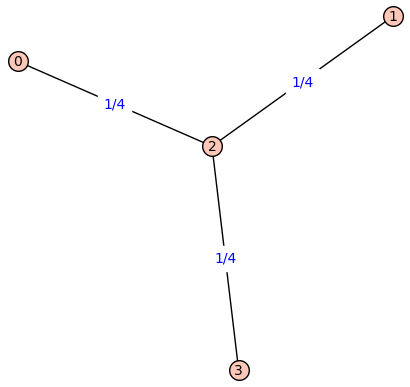

In [19]:
#
# D_4 diagram
#
D4 = Graph([(2,0,1/4),(2,1,1/4),(2,3,1/4)]);
D4.plot(edge_labels=True).show();

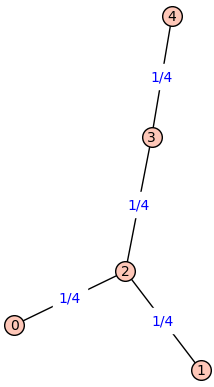

In [20]:
#
# D_5 diagram
#
D5 = Graph([(2,0,1/4),(2,1,1/4),(2,3,1/4),(3,4,1/4)]);
D5.plot(edge_labels=True).show();

In [21]:
#
# Detecting D_4 root system
#
def is_D4(aa, bb, cc, dd):
    return diagram([aa, bb, cc, dd]).is_isomorphic(D4, edge_labels=True);
#
# Counting D_4 \times A_1 systems composed by a, b, c, d and a root from roots
#
def count_D4_x_A1(roots, aa, bb, cc, dd):
    count1 = 0;
    for r in roots:
        if bL(aa,r)==0 and bL(bb,r)==0 and bL(cc,r)==0 and bL(dd,r)==0:
            count1 += 1;
    return count1;
#
# Counting D_5 systems composed by a, b, c, d and a root from roots
#
def count_D5(roots, aa, bb, cc, dd):
    count2 = 0;
    for r in roots:
        if diagram([aa, bb, cc, dd, r]).is_isomorphic(D5, edge_labels=True):
            count2 += 1;
    return count2;

In [22]:
#
# Creating Leech roots from Leech lattice elements
#
rootsL = [root(vector(v)) for v in L];
#
# Defining the roots for a D_4 system
#
[x,y,z,t] = [root(vector(v)) for v in [X,Y,Z,T]];
#
# Checking the D_4 system
#
print(is_D4(x,y,z,t));

True


In [23]:
# SANITY CHECK 
#
# Counting the number of Leech roots r such that {x,y,z,t,r} is a D_4 \times A_1 system
#
print(count_D4_x_A1(rootsL,x,y,z,t));
#
# Counting the number of Leech roots r such that {x,y,z,t,r} is a D_5 system
#
print(count_D5(rootsL,x,y,z,t));

42
168


In [24]:
#
# The Gram-Schmidt orthogonalisation process for a non-empty set W
#
def GS(W):
    ortW = [W[0]];
    for k in range(1,len(W)):
        ww = sum([bL(vv,W[k])/fL(vv)*vv for vv in ortW]);
        ortW += [W[k]-ww];
    return ortW;

In [25]:
#
# Projecting vector w onto __orthogonal__complement__ of W
#
def proj(w, W): 
    ww = sum([bL(vv,w)/fL(vv)*vv for vv in W]);
    return w - ww;

In [26]:
#
# Projecting Leech roots in rootsL onto the orthogonal complement of <x,y,z,t>
# these are the outer normals of the Borcherds polyhedron P_21
#
roots = [proj(v, GS([x,y,z,t])) for v in rootsL];

In [27]:
# SANITY CHECK
#
# We have 42 Leech roots in the orthogonal complement W^\perp of W = <x,y,z,t>
# they project onto W^\perp identically, all with length 2
#
print([fL(v) for v in roots].count(2));
#
# and 168 Leech roots that project onto W^\perp with length 1
#
print([fL(v) for v in roots].count(1));

42
168


In [28]:
#
# Creating the diagram of the Borcherds polyhedron and its automorphism group 
# (i.e. the symmetry group of the polyhedron)
# 
diag = diagram(roots);
aut = diag.automorphism_group(edge_labels=True);
#
# Number of diagram's vertices = number of facets of P_21
#
print(diag.order());
#
# Number of diagram's edges
#
print(diag.size());
#
# Order of the automorphism group
#
print(aut.order());
#
# and its structure description from GAP
#
print(aut.structure_description());

210
16149
241920
PSL(3,4) : D6


In [29]:
# ----------------------------------------------------- #
# ------- COMPUTING THE LOWER-DIMENSIONAL FACES ------- #
# ----------------------------------------------------- #

In [30]:
#
# Creating the root of the facet tree
#
P = (roots, diag, aut);
#
# Creating the facet tree
#
T = Graph();
T.add_vertex(0);
T.set_vertex(0, P);
#
# Augmenting (and pruning) the facet tree
#
facet_info(T);
for codim in range(6):    
    augment_facet_tree(T);
    prune_facet_tree(T);
    facet_info(T);

Codimension 0 Coxeter faces.
Face 0 is Coxeter, however, bad
Codimension 1 Coxeter faces.
Codimension 2 Coxeter faces.
Face 4 is Coxeter, however, bad
Face 5 is Coxeter and has a good facet
Codimension 3 Coxeter faces.
Face 15 is Coxeter and has an orthogonal facet
Face 18 is Coxeter and has an orthogonal facet
Codimension 4 Coxeter faces.
Face 42 is Coxeter, however, bad
Face 78 is Coxeter, however, bad
Face 191 is Coxeter, however, bad
Codimension 5 Coxeter faces.
Face 741 is Coxeter, however, bad
Codimension 6 Coxeter faces.
Face 1624 is Coxeter, however, bad
Face 2680 is Coxeter, however, bad
Face 4869 is Coxeter and has a good facet
Face 6093 is Coxeter, however, bad


In [31]:
#
# Faces that have a "good" or orthogonal facet according to the search above
#
good_faces = [5, 15, 18, 4869]

In [32]:
#
# Veryfying arithmeticity of faces in the facet tree
#
# IMPORTANT: here we assume that the initial polyhedron is an acute-angled quasi-arithmetic polyhedron, and 
# thus conditions (V1)--(V2) from Vinberg's criterion are __not__ verified. Only (V3) is checked 
#
#
# MOREOVER: here we essentially use the fact that it is __enough__ to check a cycle basis. Indeed, 
# we assume that 4*(edge label)^2 is an integer for each edge, and thus our only problem could 
# be a quadratic irrationality. Checking a Z_2 cycle basis will be sufficient in this case.
#
def is_Arithmetic(diag, verbose=False): 
    if diag.size() > 1000: # this search takes too long for large diagrams, so large diagrams are not checked 
        if verbose:
            print("Face given below is not checked because its diagram is too large");
        return None;     # None is returned if the number of edges is > 1000, as an indicator of no check done
    flag = all([(4*e[2] in QQ.ring_of_integers()) for e in diag.edges()]);
    if not(flag) and verbose:
        print("Our simplified approach does not apply in this case!");
        return None;
    cyc = diag.cycle_basis(output='edge');
    for c in cyc:
        cprod = prod([4*e[2] for e in c]);
        cprod = QQ(sqrt(cprod));
        if not(cprod in QQ.ring_of_integers()):
            if verbose:
                print("Face given below is not arithmetic because of (cycle, cyclic product): ", c, cprod);
            return False;
    return True;

In [33]:
#
# Checking is the "good" faces found previously are indeed arithmetic
#
for i in good_faces:
    diagram = T.get_vertex(i)[1]
    flag = is_Arithmetic(diagram)
    print("Is face {} arithmetic? {}".format(i, flag))

Is face 5 arithmetic? True
Is face 15 arithmetic? True
Is face 18 arithmetic? True
Is face 4869 arithmetic? True


In [34]:
# ----------------------------------------------------- #
# ------------------------ END ------------------------ #
# ----------------------------------------------------- #